# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import json
import re
from time import time
import random
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
import seaborn as sb

from workspace_utils import active_session

# magic word for producing visualizations in notebook
%matplotlib inline

start_time = time()
"""
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
"""

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
start = time()
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
end = time()
print('Processing time: {:.3f}s'.format(end-start))

Processing time: 7.294s


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [5]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [8]:
azdias.shape, feat_info.shape

((891221, 85), (85, 4))

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Finding missing value before converting process
azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [10]:
# Finding data type
type(feat_info['missing_or_unknown'][0]), type(azdias['AGER_TYP'][1])

(str, numpy.int64)

In [11]:
# Check whether feat_info has the same feature names of azdias dataset
feat_info['attribute'].tolist() == azdias.columns.tolist()

True

In [12]:
# Parsing error code
start = time()

missing_or_unknown = feat_info['missing_or_unknown']
missing_or_unknown = missing_or_unknown.apply(lambda x: re.sub(r"[^a-zA-Z0-9\-]", " ", x))
# a = a.apply(lambda x: re.sub(r"[\d+]", int(x), x))
missing_or_unknown = missing_or_unknown.apply(lambda x: x.split())

code = []
for error_list in missing_or_unknown:
    if len(error_list) == 0:
        code.append(error_list)
    else:
        error_list_new = []
        for error_code in error_list:
            if bool(re.search(r"[0-9]", error_code)):
                error_list_new.append(int(error_code))
            else:
                error_list_new.append(error_code)
        code.append(error_list_new)

feat_info['missing_or_unknown'] = pd.DataFrame({'error': code})

end = time()
print('Processing time: {:.3f}s'.format(end-start))

Processing time: 0.005s


In [13]:
# Replacing value into np.nan based on error code above
start = time()
for i in range(len(feat_info)):
    error_list = feat_info['missing_or_unknown'][i]
    if len(error_list) > 0:
        azdias.iloc[:, i] = azdias.iloc[:, i].replace(error_list, [np.nan] * len(error_list))
    else:
        print('{} column has no missing data or unknown data.'.format(azdias.columns[i]))
end = time()
print('Processing time: {:.3f}s'.format(end-start))

GFK_URLAUBERTYP column has no missing data or unknown data.
GREEN_AVANTGARDE column has no missing data or unknown data.
ANZ_PERSONEN column has no missing data or unknown data.
ANZ_TITEL column has no missing data or unknown data.
ANZ_HH_TITEL column has no missing data or unknown data.
KONSUMNAEHE column has no missing data or unknown data.
GEBAEUDETYP_RASTER column has no missing data or unknown data.
MOBI_REGIO column has no missing data or unknown data.
ONLINE_AFFINITAET column has no missing data or unknown data.
KBA13_ANZAHL_PKW column has no missing data or unknown data.
Processing time: 6.659s


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [14]:
# Check conversion result
azdias['AGER_TYP'][0], type(azdias['AGER_TYP'][0])

(nan, numpy.float64)

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_in_col = azdias.isna().sum()
missing_in_col

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [16]:
Q1 = np.percentile(missing_in_col, 25)
Q3 = np.percentile(missing_in_col, 75)
IQR = Q3 - Q1
IQR
top_limit = 1.5 * IQR

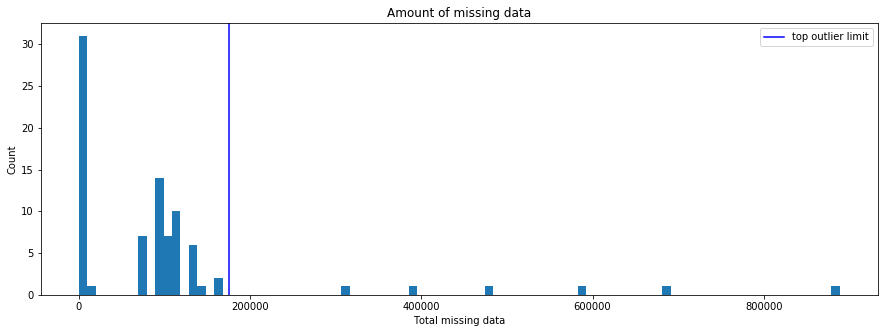

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.subplots(figsize=(15, 5))
plt.hist(missing_in_col, bins=90)
plt.title('Amount of missing data')
plt.xlabel('Total missing data')
plt.axvline(x=top_limit, color='b', linestyle='-', label='top outlier limit')
plt.legend()
plt.ylabel('Count');

In [18]:
# # Investigate patterns in the amount of missing data in each column.
# ind = range(len(missing_in_col))

# plt.subplots(figsize=(16,5))
# plt.bar(ind, missing_in_col * 100 / len(azdias))
# plt.title('Proportion of missing data')
# plt.xticks(ind, missing_in_col.index, rotation=90)
# plt.xlabel('Features')
# plt.axhline(y=np.mean(missing_in_col * 100 / len(azdias)), color='b', linestyle='-', label='mean')
# plt.ylabel('Proportion (%)')
# plt.legend();


In [19]:
index = [i for i, value in enumerate(missing_in_col) if value - top_limit > 0]
index

[0, 11, 40, 43, 47, 64]

0.689471960067749 s


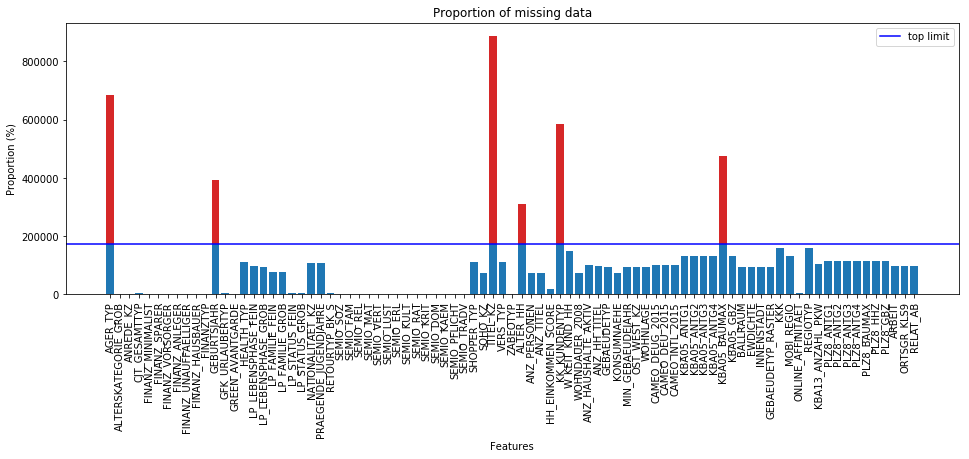

In [20]:
start = time()
ind = range(len(missing_in_col))

plt.subplots(figsize=(16,5))
plt.bar(ind, missing_in_col)
index = [i for i, value in enumerate(missing_in_col) if value - top_limit > 0]
plt.bar(index, missing_in_col[index] - top_limit, bottom=top_limit, color='#d62728')
plt.title('Proportion of missing data')
plt.xticks(ind, missing_in_col.index, rotation=90)
plt.xlabel('Features')
plt.axhline(y=top_limit, color='b', linestyle='-', label='top limit')
plt.ylabel('Proportion (%)')
plt.legend();
end = time()
print(end - start, 's')

In [21]:
above_limit = missing_in_col[missing_in_col > top_limit] * 100 / len(azdias)
above_limit = above_limit.reset_index().rename(columns={'index': 'Column', 0: 'Missing value (%)'})
above_limit

,Column,Missing value (%)
0,AGER_TYP,76.955435
1,GEBURTSJAHR,44.020282
2,TITEL_KZ,99.757636
3,ALTER_HH,34.813699
4,KK_KUNDENTYP,65.596749
5,KBA05_BAUMAX,53.468668


In [22]:
# Getting column names need to be dropped
drop_column = missing_in_col[missing_in_col > top_limit].index.tolist()
drop_column

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [23]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias = azdias.drop(drop_column, axis=1)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column


Here we add desription from data dictionary:

In [24]:
desc = ['Best-ager typology', 'Year of birth', 'Academic title flag', 
        'Birthdate of head of household', 'Consumer pattern over past 12 months', 
        'Most common building type within the microcell']
above_limit['Description'] = desc
above_limit

,Column,Missing value (%),Description
0,AGER_TYP,76.955435,Best-ager typology
1,GEBURTSJAHR,44.020282,Year of birth
2,TITEL_KZ,99.757636,Academic title flag
3,ALTER_HH,34.813699,Birthdate of head of household
4,KK_KUNDENTYP,65.596749,Consumer pattern over past 12 months
5,KBA05_BAUMAX,53.468668,Most common building type within the microcell


In [25]:
# Find average of missing data in percentage
missing_in_col.describe()['mean'] * 100 / len(azdias)

11.05413940702765

Here we got some outlier in term of missing data. While other column has average of 11.05% of missing data, column in table above has much higher missing value. I categorize those column above as outlier based on 1.5 \* IQR rule. 

Let's see some column with missing data there. Almost all data in TITEL_KZ is missing, followed by AGER_TYP with 77% of the data is missing.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
missing_in_row = azdias.isna().sum(axis=1)

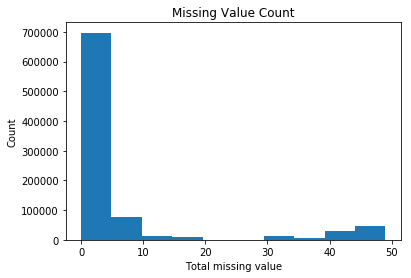

In [27]:
# plt.subplots(figsize=(8,5))
plt.hist(missing_in_row)
plt.xlabel('Total missing value')
plt.ylabel('Count')
plt.title('Missing Value Count');

Let's set the missing value threshold to 25.

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# threshold = 1.5 * (np.percentile(missing_in_row, 75) - np.percentile(missing_in_row, 25))
threshold = 25
under_threshold = missing_in_row[missing_in_row <= threshold]
over_threshold = missing_in_row[missing_in_row > threshold]

In [29]:
def compare_missing(column):
    color = sb.color_palette()[0]
    
    plt.subplots(figsize=(16, 5))
    
    plt.subplot(1, 2, 1)
    sb.countplot(azdias.loc[under_threshold.index, column])
    plt.title('Under threshold')
    plt.xlabel('Missing number')
    
    plt.subplot(1, 2, 2)
    sb.countplot(azdias.loc[over_threshold.index, column])
    plt.title('Over threshold')
    plt.xlabel('Missing number')
    
    plt.suptitle(column)

In [30]:
# Selecting columns with few missing value
missing_in_col.sort_values()[:40]

ZABEOTYP                     0
SEMIO_TRADV                  0
SEMIO_PFLICHT                0
SEMIO_KAEM                   0
SEMIO_DOM                    0
SEMIO_KRIT                   0
SEMIO_RAT                    0
SEMIO_KULT                   0
SEMIO_ERL                    0
SEMIO_LUST                   0
SEMIO_VERT                   0
SEMIO_MAT                    0
SEMIO_REL                    0
SEMIO_SOZ                    0
SEMIO_FAM                    0
FINANZ_VORSORGER             0
ANREDE_KZ                    0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_ANLEGER               0
FINANZ_UNAUFFAELLIGER        0
FINANZ_HAUSBAUER             0
GREEN_AVANTGARDE             0
FINANZTYP                    0
ALTERSKATEGORIE_GROB      2881
GFK_URLAUBERTYP           4854
LP_STATUS_GROB            4854
LP_STATUS_FEIN            4854
ONLINE_AFFINITAET         4854
RETOURTYP_BK_S            4854
CJT_GESAMTTYP             4854
HH_EINKOMMEN_SCORE       18348
WOHNDAUE

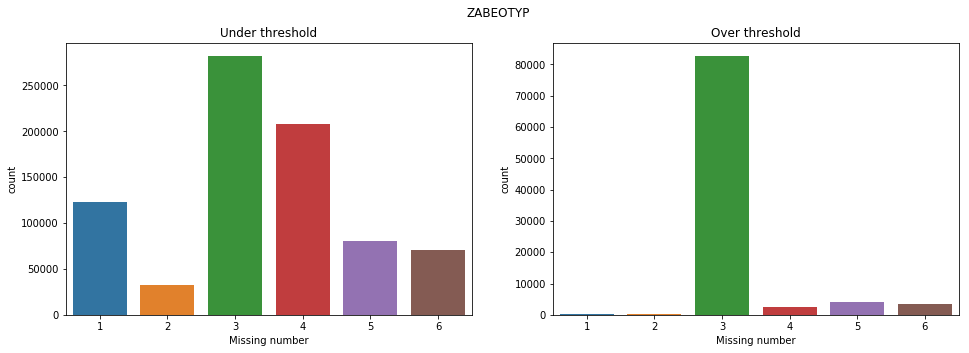

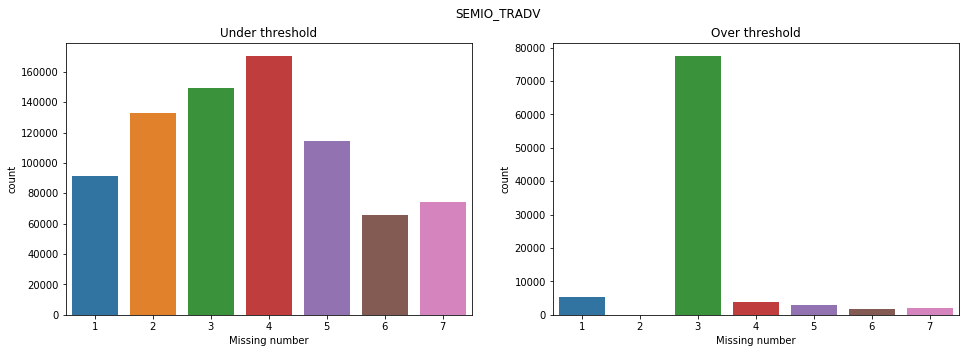

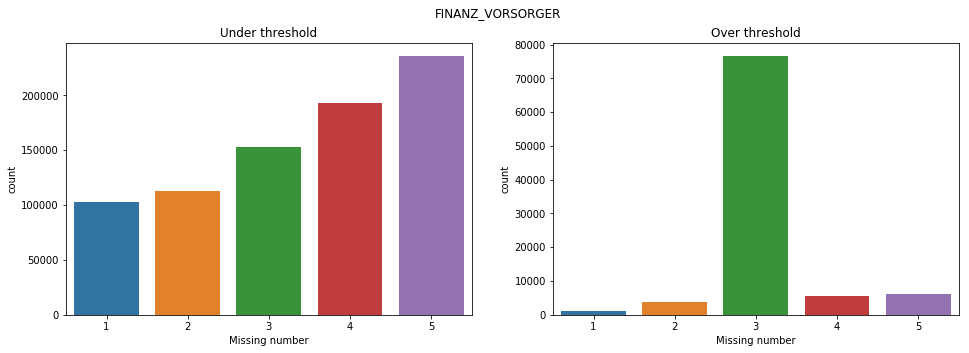

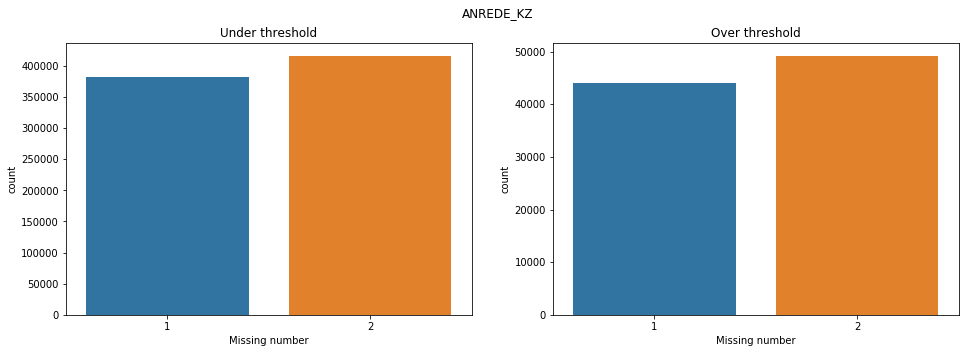

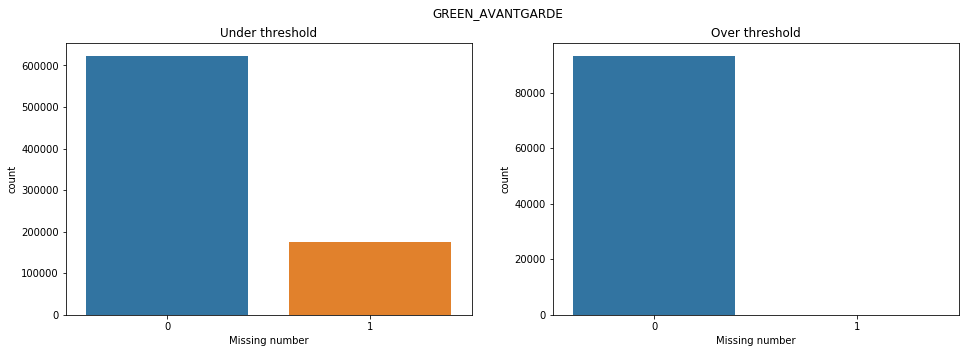

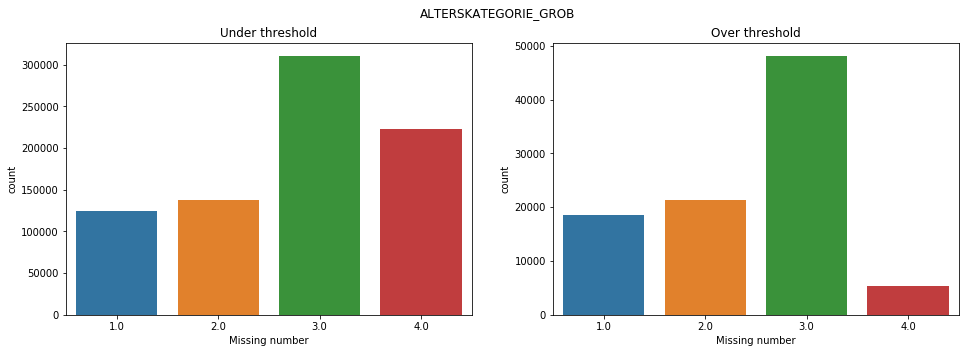

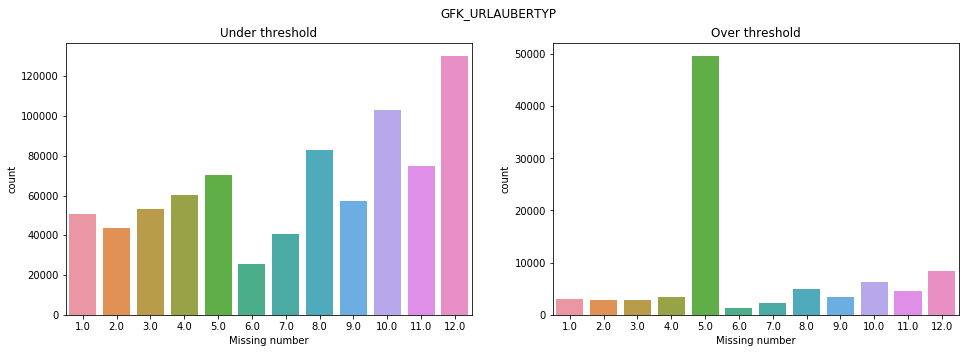

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# Plotting comparation between 7 features with lowest data missing value
column_list = ['ZABEOTYP',
'SEMIO_TRADV',
'FINANZ_VORSORGER',
'ANREDE_KZ',
'GREEN_AVANTGARDE',
'ALTERSKATEGORIE_GROB',
'GFK_URLAUBERTYP']

for column in column_list:
    compare_missing(column)

In [32]:
df = azdias.copy().loc[under_threshold.index]
df_many_missing = azdias.copy().loc[over_threshold.index]

#### Discussion 1.1.3: Assess Missing Data in Each Row

Dataset was divided into two subsets which were row with few missing value and row with many missing value. The idea of this segmentation came up after plotting histogram of row missing value. The histogram shows there is two subset of missing value number. The value of 25 was choosen as threshold value between few missing value and many missing value subsets. Distribution of values for seven features where there are no or few missing values, between the two subsets then compared using Countplot. The comparation that was made suggest that those two segments has different data distribution. 

If the subsets have similiar data distribution, dropping the row with missing value won't be a problem. Information held by remaining data still representing information from the whole data. In case they have different distribution, just like the dataset we have, we cannot simply drop those row with missing values because it will induce bias to our dataset. Thus, dataset was divided and saved for further use.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_list = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
for category in categorical_list:
    if category in drop_column:
        categorical_list.remove(category)

binary_cat = []
multi_level_cat = []
binary_encoded = []
cat_dict= {}

for category in categorical_list:
    unique_value = df[category].value_counts().sort_index().index.tolist()
    item = {category: unique_value}
    cat_dict.update(item)
    if len(unique_value) > 2:
        multi_level_cat.append(category)
    else:
        if (all(isinstance(value, int) for value in unique_value) \
            | all(isinstance(value, float) for value in unique_value)):
            binary_cat.append(category)
        else:
            binary_encoded.append(category)


In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.
for column in binary_cat:
    for i, val in enumerate(cat_dict.get(column)):
        df[column].replace(val, i, inplace=True)

for column in binary_encoded:
    for i, val in enumerate(cat_dict.get(column)):
        df[column].replace(val, i, inplace=True)

In [36]:
# Re-encode categorical variable(s) to be kept in the analysis.
df = pd.get_dummies(df, columns=multi_level_cat)
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,1,0,0,0,0,0,0


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There was several steps taken to encode categorical features. Before encoding, I searched category type for each category features listed on `feat_info`. Then, all binary categorical features were encoded with value 0 and 1. After that, all multi level category were encoded using `pd.get_dummies`. No feature were dropped in this step because there was no difficulty in encoding process.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
generation_dict = {0:[1.0, 2.0], 1:[3.0, 4.0], 2:[5.0, 6.0, 7.0], 3:[8.0, 9.0], 4:[10.0, 11.0, 12.0, 13.0], 5:[14.0, 15.0]}
mainstream_dict = {1:[1, 3, 5, 8, 10, 12, 14]}

def convert_generation(value):
    try:
        for key, val_list in generation_dict.items():
            if value in val_list:
                return key
    except:
        return np.nan

def convert_movement(value):
    try:
        for key, val_list in mainstream_dict.items():
            if value in val_list:
                return key
            else:
                return 0
    except:
        return np.nan

df['generation'] = df['PRAEGENDE_JUGENDJAHRE'].apply(convert_generation)
df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(convert_movement)

In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def convert_wealth(value):
    try:
        return int(value[0])
    except:
        return np.nan

def convert_life_stage(value):
    try:
        return int(value[1])
    except:
        return np.nan 

df['wealth'] = df['CAMEO_INTL_2015'].apply(convert_wealth)
df['life_stage'] = df['CAMEO_INTL_2015'].apply(convert_life_stage)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Data with mixed categorical type were translated into new features. Data in `PRAEGENDE_JUGENDJAHRE` were split into `generation` and `movement` by mapping value described in `data_dictionary.md`. The same way was applied to data in `CAMEO_INTL_2015` resulting `wealth` and `life_stage`. Encoding was not required because the new features were ordinal categorical data. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [39]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [40]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info)):
        error_list = feat_info['missing_or_unknown'][i]
        if len(error_list) > 0:
            df.iloc[:, i] = df.iloc[:, i].replace(error_list, [np.nan] * len(error_list))
        else:
            print('{} column has no missing data or unknown data.'.format(df.columns[i]))
    
    # remove selected columns and rows, ...
    df = df.drop(drop_column, axis=1)
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    missing_in_row = df.isna().sum(axis=1)
    threshold = 25
    
    under_threshold = missing_in_row[missing_in_row <= threshold]
    over_threshold = missing_in_row[missing_in_row > threshold]
    
    df_many_missing = df.copy().loc[over_threshold.index]
    df = df.loc[under_threshold.index]
        
    # select, re-encode, and engineer column values.
    
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    categorical_list = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()
    for category in categorical_list:
        if category in drop_column:
            categorical_list.remove(category)

    binary_cat = []
    multi_level_cat = []
    binary_encoded = []
    cat_dict= {}

    for category in categorical_list:
        unique_value = df[category].value_counts().sort_index().index.tolist()
        item = {category: unique_value}
        cat_dict.update(item)
        if len(unique_value) > 2:
            multi_level_cat.append(category)
        else:
            if (all(isinstance(value, int) for value in unique_value) \
                | all(isinstance(value, float) for value in unique_value)):
                binary_cat.append(category)
            else:
                binary_encoded.append(category)
    
    for column in binary_cat:
        for i, val in enumerate(cat_dict.get(column)):
            df[column].replace(val, i, inplace=True)

    for column in binary_encoded:
        for i, val in enumerate(cat_dict.get(column)):
            df[column].replace(val, i, inplace=True)
    
    df = pd.get_dummies(df, columns=multi_level_cat)
    
    generation_dict = {0:[1.0, 2.0], 1:[3.0, 4.0], 2:[5.0, 6.0, 7.0], 3:[8.0, 9.0], 4:[10.0, 11.0, 12.0, 13.0], 5:[14.0, 15.0]}
    mainstream_dict = {1:[1, 3, 5, 8, 10, 12, 14]}

    def convert_generation(value):
        try:
            for key, val_list in generation_dict.items():
                if value in val_list:
                    return key
        except:
            return np.nan

    def convert_movement(value):
        try:
            for key, val_list in mainstream_dict.items():
                if value in val_list:
                    return key
                else:
                    return 0
        except:
            return np.nan

    df['generation'] = df['PRAEGENDE_JUGENDJAHRE'].apply(convert_generation)
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(convert_movement)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    def convert_wealth(value):
        try:
            return value[0]
        except:
            return np.nan

    def convert_life_stage(value):
        try:
            return value[1]
        except:
            return np.nan 

    df['wealth'] = df['CAMEO_INTL_2015'].apply(convert_wealth)
    df['life_stage'] = df['CAMEO_INTL_2015'].apply(convert_life_stage)
    
    df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
    # Return the cleaned dataframe.
    return df, df_many_missing
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

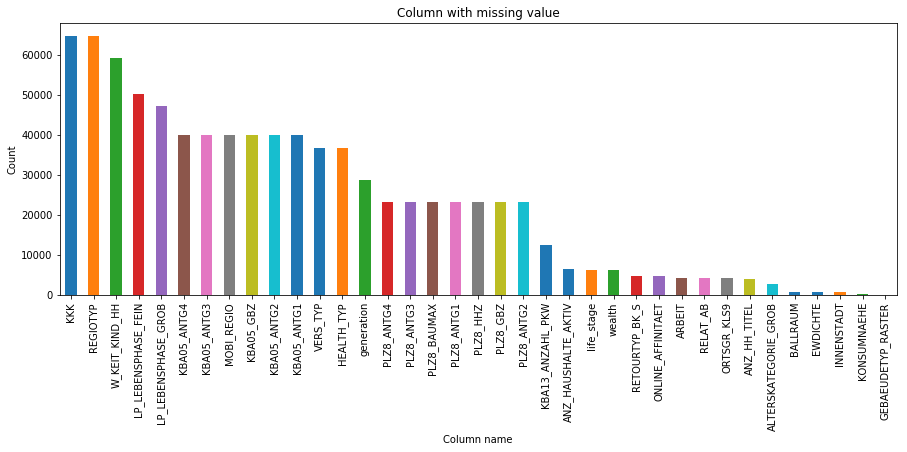

In [41]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Plotting column with missing value count
plt.subplots(figsize=(15,5))
df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False).plot(kind='bar')
plt.title('Column with missing value')
plt.xlabel('Column name')
plt.ylabel('Count');

In [42]:
# Information list of column with missing value 
index = df.isna().sum()[df.isna().sum() > 0].index.values.tolist()
for rem in ['generation', 'wealth', 'life_stage']:
    index.remove(rem)
feat_info.loc[feat_info['attribute'].isin(index)]

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
14,HEALTH_TYP,person,ordinal,"[-1, 0]"
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
23,RETOURTYP_BK_S,person,ordinal,[0]
41,VERS_TYP,person,categorical,[-1]
48,W_KEIT_KIND_HH,household,ordinal,"[-1, 0]"
50,ANZ_HAUSHALTE_AKTIV,building,numeric,[0]
51,ANZ_HH_TITEL,building,numeric,[]
53,KONSUMNAEHE,building,ordinal,[]


In [43]:
# Importing libraries
start = time()
from sklearn.preprocessing import Imputer, StandardScaler

# Imputing missing values
imp = Imputer(strategy='median')
imputed_df = imp.fit_transform(df)

end = time()
print('Processing time: {:.3f}m'.format((end-start)/60))

Processing time: 3.863m


In [44]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
processed_df = scaler.fit_transform(imputed_df)

In [45]:
# Defining funtion for feature scaling
def do_scaling(df, strategy):
    from sklearn.preprocessing import Imputer, StandardScaler
    
    # Imputing missing values
    imp = Imputer(strategy='median')
    imputed_df = imp.fit_transform(df)
    
    # Apply feature scaling to the general population demographics data.
    scaler = StandardScaler()
    processed_df = scaler.fit_transform(imputed_df)
    
    return processed_df

### Discussion 2.1: Apply Feature Scaling

Our data now has been cleaned from missing values and scaled. Here is the step taken to clean missing value and scale the data:
1. First, we need to find information about the column with missing value. On table we created from `feat_info` above, we can see that there is several data type range from numeric to mixed categorical type. So it is better if we impute the missing value with some int value because data with category of 1.25 does not make any sense. It is a good practice to fill the missing value with median using Sklearn `Imputer`.
2. Then our data were scaled using `StandardScaler`. This procedure is simple and straightforward.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [46]:
# Apply PCA to the data.
def do_pca(df, n_components):
    from sklearn.decomposition import PCA
    pca = PCA(n_components, random_state=42)
    df_pca = pca.fit_transform(df, n_components)
    return pca, df_pca

In [47]:
# Apply PCA to the data.
pca, df_pca = do_pca(processed_df, 196)

In [48]:
# Investigate the variance accounted for by each principal component.
def plot_pca(pca):
    exp_car_ratio = pca.explained_variance_ratio_
    ind = range(len(exp_car_ratio))
    plot_val = np.cumsum(exp_car_ratio)

    plt.subplots(figsize=(16,5))
    plt.bar(ind, exp_car_ratio)
    plt.plot(ind, plot_val)
    for i in ind:
            plt.annotate(r"%s%%" % ((str(exp_car_ratio[i]*100)[:4])), (ind[i]+0.2, exp_car_ratio[i]), va="bottom", ha="center", fontsize=3)
    plt.title('Explained Variance per Principal Component')
    plt.xlabel('Principal component')
    plt.ylabel('Variance explained(%)');

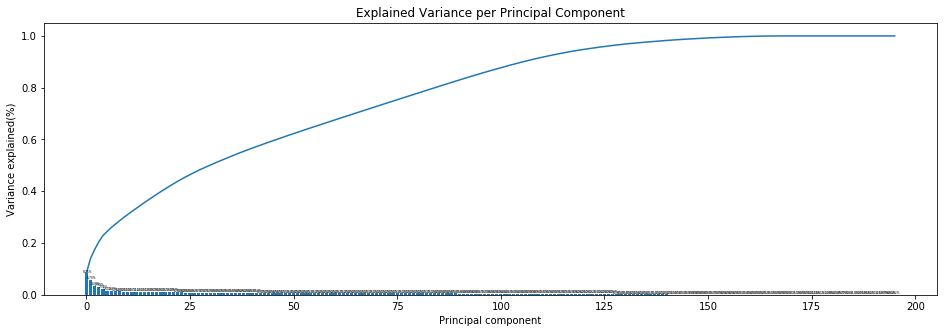

In [49]:
# Investigate the variance accounted for by each principal component.
plot_pca(pca)


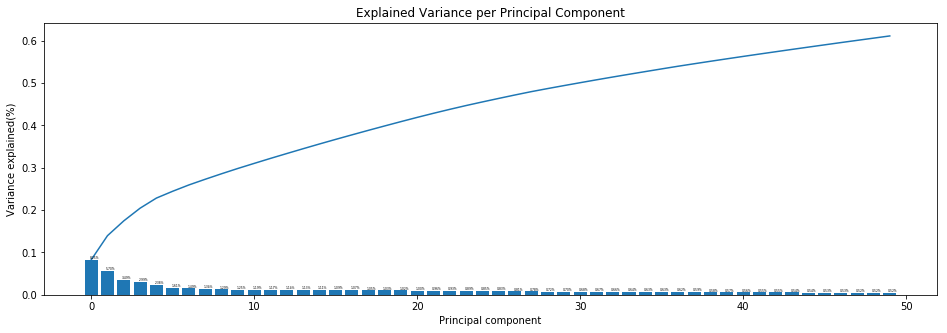

In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, df_pca = do_pca(processed_df, 50)
plot_pca(pca)

### Discussion 2.2: Perform Dimensionality Reduction

PCA was applied to our dataset to reduce its number of feature. First, I used all features for PCA process then I plotted the cumulative sum of variance explained by number of principal component. After looking the plot, I decided to select 50 top components to represent around 60% of data variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [51]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def plot_weight(df, pca, n_component, shown_weight_num):
    weight = pd.DataFrame(pca.components_, columns=df.columns).loc[n_component]
    weight = weight.sort_values()
    top_bot_num = shown_weight_num
    features = weight.index
    ind = range(2 * top_bot_num)
    
    plt.subplots(figsize=(8,5))
    plt.bar(ind, weight[:top_bot_num].append(weight[-top_bot_num:]))
    plt.xticks(ind, features[:top_bot_num].append(features[-top_bot_num:]), rotation=90)
    plt.rc('axes', axisbelow=True);
    plt.grid(alpha=0.5)
    plt.title('Component '+str(n_component+1)+' Biggest Weight')
    plt.ylabel('Weight')
    plt.xlabel('Components')
    plt.axhline(y=0);
    
    print('- Negative weight features: ', ', '.join(features[:top_bot_num].tolist()))
    print('- Positive weight features: ', ', '.join(features[-top_bot_num:].tolist()))

- Negative weight features:  MOBI_REGIO, KBA05_ANTG1, PLZ8_ANTG1, FINANZ_MINIMALIST, KBA05_GBZ
- Positive weight features:  PLZ8_ANTG4, PLZ8_ANTG3, wealth, HH_EINKOMMEN_SCORE, LP_STATUS_GROB_1.0


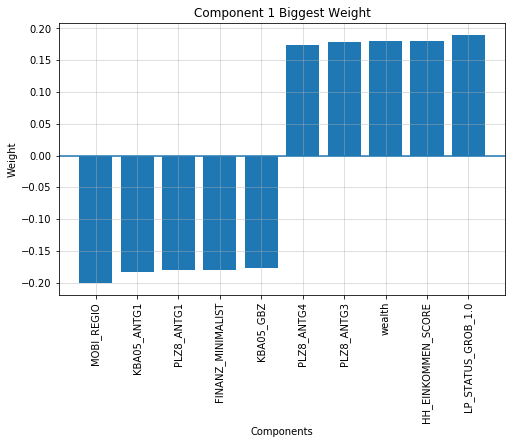

In [52]:
plot_weight(df, pca, 0, 5)

- Negative weight features:  generation, FINANZ_SPARER, SEMIO_REL, FINANZ_UNAUFFAELLIGER, SEMIO_TRADV
- Positive weight features:  SEMIO_LUST, SEMIO_ERL, ZABEOTYP_3, FINANZ_VORSORGER, ALTERSKATEGORIE_GROB


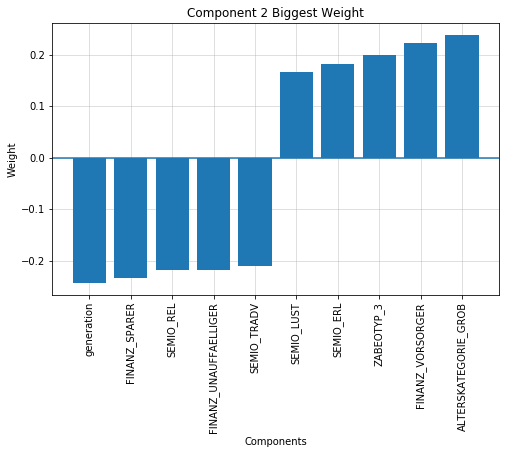

In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_weight(df, pca, 1, 5)

- Negative weight features:  ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL
- Positive weight features:  FINANZTYP_5, SEMIO_KULT, SEMIO_SOZ, SEMIO_FAM, SEMIO_VERT


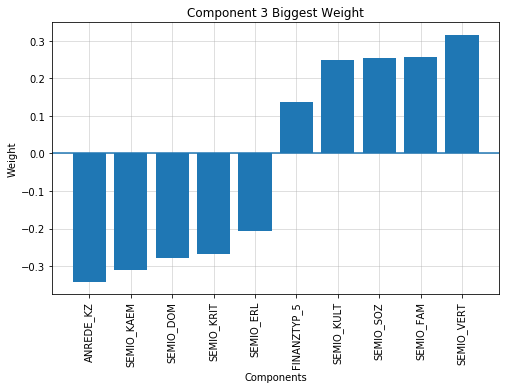

In [54]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_weight(df, pca, 2, 5)

### Discussion 2.3: Interpret Principal Components

First component:
- Negative weight features:  MOBI_REGIO, KBA05_ANTG1, PLZ8_ANTG1, FINANZ_MINIMALIST, KBA05_GBZ
- Positive weight features:  PLZ8_ANTG4, PLZ8_ANTG3, wealth, HH_EINKOMMEN_SCORE, LP_STATUS_GROB_1.0<br>

Second component:
- Negative weight features:  generation, FINANZ_SPARER, SEMIO_REL, FINANZ_UNAUFFAELLIGER, SEMIO_TRADV
- Positive weight features:  SEMIO_LUST, SEMIO_ERL, ZABEOTYP_3, FINANZ_VORSORGER, ALTERSKATEGORIE_GROB<br>

Third component:
- Negative weight features:  ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_ERL
- Positive weight features:  FINANZTYP_5, SEMIO_KULT, SEMIO_SOZ, SEMIO_FAM, SEMIO_VERT<br>

Positive weight means that a higher score on that variable is associated with a higher score on the component, if the value is negative, then a higher score implies a lower score on the component. For analysis, we will use first component's features with positive weight which are PLZ8_ANTG4, PLZ8_ANTG3, wealth, HH_EINKOMMEN_SCORE, LP_STATUS_GROB_1.0.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.

def elbow_plot(data, lower_k, upper_k):
    timer_start = time()
    score_k = []
    diff = upper_k - lower_k

    for k in range(lower_k, upper_k):
        kmeans_k = KMeans(k, random_state=42)
        model_k = kmeans_k.fit(data)
        score_k.append(np.abs(model_k.score(data)))
        timer_now = time()
        print(f'Finished fitting data for K = {k}.. '
              f'Elapsed time: {(timer_now - timer_start)/3600:.2f}h')

    plt.subplots(figsize=(8,5))
    plt.plot(range(lower_k, upper_k), score_k, marker='o')
    plt.xticks(range(lower_k, upper_k), range(lower_k, upper_k))
    plt.title('KMeans Score Among K Values')
    plt.xlabel('Number of cluster (K)')
    plt.ylabel('Average distance to cluster center (SSE)');
    

Finished fitting data for K = 10.. Elapsed time: 0.04h
Finished fitting data for K = 11.. Elapsed time: 0.09h
Finished fitting data for K = 12.. Elapsed time: 0.16h
Finished fitting data for K = 13.. Elapsed time: 0.23h
Finished fitting data for K = 14.. Elapsed time: 0.28h
Finished fitting data for K = 15.. Elapsed time: 0.35h
Finished fitting data for K = 16.. Elapsed time: 0.42h
Finished fitting data for K = 17.. Elapsed time: 0.51h
Finished fitting data for K = 18.. Elapsed time: 0.60h
Finished fitting data for K = 19.. Elapsed time: 0.68h
Finished fitting data for K = 20.. Elapsed time: 0.79h
Finished fitting data for K = 21.. Elapsed time: 0.89h
Finished fitting data for K = 22.. Elapsed time: 0.98h
Finished fitting data for K = 23.. Elapsed time: 1.09h
Finished fitting data for K = 24.. Elapsed time: 1.19h
Finished fitting data for K = 25.. Elapsed time: 1.29h
Finished fitting data for K = 26.. Elapsed time: 1.42h
Finished fitting data for K = 27.. Elapsed time: 1.54h
Finished f

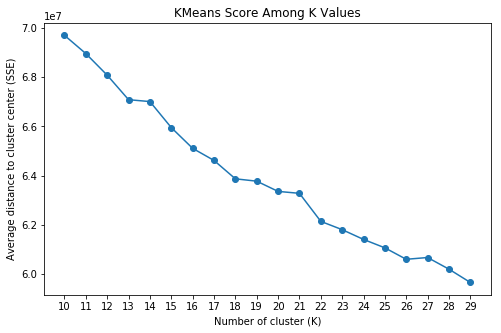

In [56]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
with active_session():
    elbow_plot(df_pca, 10, 30)

There is no obvious single "elbow" found in the plot above. So K = 13 was choosen because it has smallest "elbow" degree.

In [ ]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
start = time()

with active_session():
    kmeans_k = KMeans(13, random_state=42)
    kmeans_k.fit(df_pca)
    cluster_prediction = kmeans_k.predict(df_pca)

end = time()
print('Processing time: {:.3f}m'.format((end-start)/60))


### Discussion 3.1: Apply Clustering to General Population

Clustering was done using Sklearn's `Kmeans`. Before defining the number of cluster, first I tried to find elbow by plotting several number of clusters vs average distance to centroid. After creating elbow plot above, we get some interesting finding here. While there is no obvious single elbow in the plot, we can see that there is a point where elbow has the smallest degree. So the K value of 13 is reasonable and then we choose 13 as number of cluster of general population dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [ ]:
customers.shape, feat_info.shape

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers, customers_many_missing = clean_data(customers)

In [ ]:
# Checking cleaned columns difference
customers.columns[~customers.columns.isin(df.columns)], df.columns[~df.columns.isin(customers.columns)]


Looks like we have different number of features between general dataset and customer subset dataset. Our code above show that there is no `GEBAEUDETYP_5.0` features in customer dataset. Let's process it.

In [ ]:
# Set up inserted column properties
loc = df.columns.get_loc('GEBAEUDETYP_5.0')
value = [0] * len(customers)

# Inserting new column
customers.insert(loc, 'GEBAEUDETYP_5.0', value)

In [ ]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_imputed = imp.transform(customers)
customers_scaled = scaler.transform(customers_imputed)
customers_pca = pca.transform(customers_scaled)
customers_cluster = kmeans_k.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Creating cluster data for general population dataset
missing_gen_cluster = np.full((len(df_many_missing)), 99)
general_array = np.concatenate((cluster_prediction, missing_gen_cluster))
general = {'proportion': pd.Series(general_array).value_counts(normalize=True).sort_index(), 'data': 'general'}
general = pd.DataFrame(general).reset_index().rename(columns={'index': 'cluster'})
general

In [ ]:
# Creating cluster data for customer dataset
missing_cus_cluster = np.full((len(customers_many_missing)), 99)
customer_array = np.concatenate((customers_cluster, missing_cus_cluster))
customer = {'proportion': pd.Series(customer_array).value_counts(normalize=True).sort_index(), 'data': 'customer'}
customer = pd.DataFrame(customer).reset_index().rename(columns={'index': 'cluster'})
customer

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
proportion_comparison = pd.concat([general, customer])
sb.barplot(data=proportion_comparison, x='cluster', y='proportion', hue='data')
plt.title('Cluster Proportion Comparison\nBetween General and Customer Data');


In [ ]:
# Finding over and under representated data
representation = customer['proportion'] - general['proportion']
representasion_df = pd.DataFrame(representation)
representasion_df.insert(0, 'cluster', general['cluster'])
representasion_df = representasion_df.rename(columns={'proportion': 'prop_diff'})
representasion_df

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_represented = representasion_df[representasion_df['prop_diff'] >= 0].sort_values(by='prop_diff', ascending=False)
over_represented

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_represented = representasion_df[representasion_df['prop_diff'] < 0].sort_values(by='prop_diff')
under_represented

The cluster that over representated customer dataset is cluster 4. Here is the features explanation associated with cluster 4.

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
df_cluster4_pca = df_pca[cluster_prediction == 4]
df_cluster4_processed = pca.inverse_transform(df_cluster4_pca)
df_cluster4 = scaler.inverse_transform(df_cluster4_processed)
df_cluster4 = pd.DataFrame(df_cluster4, columns=df.columns)
df_cluster4[['wealth', 'HH_EINKOMMEN_SCORE', 'LP_STATUS_GROB_1.0', 'PLZ8_ANTG4', 'PLZ8_ANTG3']].describe()

The cluster that over representated customer dataset is cluster 12. Here is the features explanation associated with cluster 12.

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
df_cluster12_pca = df_pca[cluster_prediction == 12]
df_cluster12_processed = pca.inverse_transform(df_cluster12_pca)
df_cluster12 = scaler.inverse_transform(df_cluster12_processed)
df_cluster12 = pd.DataFrame(df_cluster12, columns=df.columns)
df_cluster12[['wealth', 'HH_EINKOMMEN_SCORE', 'LP_STATUS_GROB_1.0', 'PLZ8_ANTG4', 'PLZ8_ANTG3']].describe()

In [ ]:
# Additional information for cluster 4
df_cluster4[['ANREDE_KZ', 'ALTERSKATEGORIE_GROB']].describe()

In [ ]:
# Additional information for cluster 12
df_cluster12[['ANREDE_KZ', 'ALTERSKATEGORIE_GROB']].describe()

### Discussion 3.3: Compare Customer Data to Demographics Data

From our analysis above, the data sugesting that there are group of people which are over represented and then under represented compared to demographics data of Germany Population. Group that over represented came from prosperous households, has very high income, has fair supplied energy consumption typology, with low family number houses in the microcell. On the other side, group that under represented came from less affluent households, has very low income, has fair supplied energy consumption typology, with high family number houses in the microcell.

I also searched for additional information that is not shown up in the principal component analysist. I am interested to find age and gender information between the two groups. As we can see above, over represented group has. Meanwhile, the under represented group has

In [ ]:
end_time = time()
print('Total processing time: {:.3f}h'.format((end_time-start_time)/3600))